# Add data to colab

In [ ]:
!rm -rf /content/sample_data
!git clone https://github.com/MoritzCermann/semantic-segmentation-camvid.git

# move files into /content
!mv /content/semantic-segmentation-camvid/* /content/
!rm -rf /content/semantic-segmentation-camvid

Cloning into 'semantic-segmentation-camvid'...
remote: Enumerating objects: 1432, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 1432 (delta 5), reused 18 (delta 5), pack-reused 1413
Receiving objects: 100% (1432/1432), 569.63 MiB | 18.45 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (1408/1408), done.


# Initialize model and data

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

from utils import load_data_from_dir

from google.colab import drive
drive.mount('/content/drive')

checkpoint_dir = '/content/checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = os.getcwd()

# Create dataframe
train_image_df = pd.read_csv(base_dir + '/data/camvid_train.txt', header=None, sep=' ', names=['image', 'mask']) # 367 rows
val_image_df = pd.read_csv(base_dir + '/data/camvid_val.txt', header=None, sep=' ', names=['image', 'mask']) # 101 rows
test_image_df = pd.read_csv(base_dir + '/data/camvid_test.txt', header=None, sep=' ', names=['image', 'mask']) # 233 rows

# Used classes
classes = [
    'Sky', 'Building', 'Pole', 'Road', 'Pavement', 'Tree',
    'SignSymbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist',
    'Void'
    ]

n_class = 11 # class 'Void' (backgorund) is ignored

In [ ]:
# Load data into dataframe
image_dim = (256, 256)
train_images, train_masks = load_data_from_dir(train_image_df, True, image_dim)
val_images, val_masks = load_data_from_dir(val_image_df, True, image_dim)
test_images, test_masks = load_data_from_dir(test_image_df, True, image_dim)

print(train_images.shape)
print(train_masks.shape)
print(val_images.shape)
print(val_masks.shape)
print(test_images.shape)
print(test_masks.shape)

367it [00:12, 28.43it/s]
101it [00:03, 31.25it/s]
233it [00:08, 27.33it/s]


(367, 256, 256, 3)
(367, 256, 256, 1)
(101, 256, 256, 3)
(101, 256, 256, 1)
(233, 256, 256, 3)
(233, 256, 256, 1)


In [ ]:
# Testing - not used
def compute_class_weights(masks, num_classes):
    flat_masks = masks.flatten()
    class_weights = np.zeros(num_classes)
    for i in range(num_classes):
        class_weights[i] = np.sum(flat_masks == i)
    class_weights = class_weights / flat_masks.size
    class_weights = 1 / (class_weights + 1e-10)
    return class_weights

In [ ]:
# Testing - not used
class_weights = compute_class_weights(train_masks, n_class)
print("Class Weights:", class_weights)

Class Weights: [  5.87845826   4.25268974 100.60783622   3.22015855  20.65052859
  10.24853025  85.24381112  88.65029592  15.9064279  141.93149804
 342.28540981]


In [ ]:
# Build the model
import importlib
import build_model

file_modified = False; # if you change model architecture in build_model.py - Defaul: false

if file_modified:
  importlib.reload(build_model)
from build_model import build_unet

unet_model = build_unet(input_shape = train_images.shape[1:],
                        num_classes = 11,
                        num_filters = 16,
                        kernel_size = 3)

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['activation[0][0]']          
                                                                                              

In [ ]:
# Set loss and compile model
from tensorflow.keras.optimizers import Adam
tf.keras.backend.clear_session()

# SCCE loss saves memory
SCCE = tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=255) # ignore void class in loss calculation
adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08) # the default settings mentioned in the paper "Adam..."

unet_model.compile(optimizer=adam, loss=SCCE, metrics='accuracy')

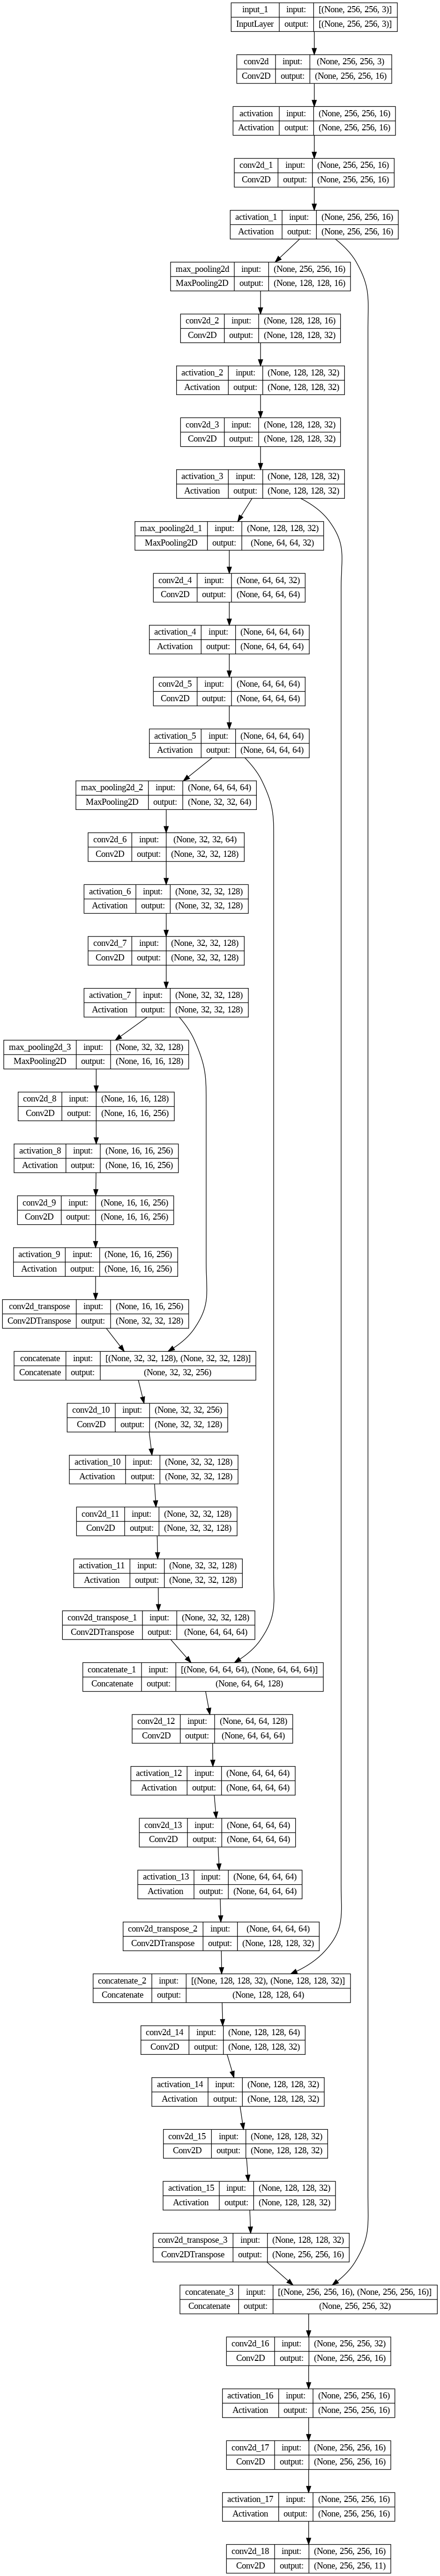

In [ ]:
# Plot network architecture
from tensorflow.keras.utils import plot_model
plot_model(unet_model, show_shapes=True, show_layer_names=True)

# Train the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

train_val = False   # Use train & valid sets to optimize hyperparameters
train_test = True  # Use  train and valid data to train a final model and then evaluate on the test set

# Set parameters
checkpoint_name = 'unet_training_epoch_02.h5' # Leave empty if no checkpoint available yet
checkpoint_from_drive = False
epoch = 63


# Use if you want to continue traning with a saved model
initial_epoch = 0

if checkpoint_from_drive:
    latest_checkpoint = '/content/drive/MyDrive/ColabNotebooks/' + 'unet_training_epoch_latest.h5'
else:
    latest_checkpoint = '/content/checkpoints/' + checkpoint_name

if os.path.exists(latest_checkpoint):
    unet_model = tf.keras.models.load_model(latest_checkpoint)
    initial_epoch = int(checkpoint_name.split('_')[-1].split('.')[0])
    print(f"Training will resume from checkpoint: {latest_checkpoint}")
    print(f"Initial epoch: {initial_epoch}")

# Actual training

In [ ]:
# Set up ModelCheckpoint for saving checkpoints local and on drive
checkpoint_path_local = os.path.join(checkpoint_dir, 'unet_training_epoch_{epoch:02d}.h5')
model_checkpoint_local = ModelCheckpoint(filepath=checkpoint_path_local,
                              save_weights_only=False,
                              save_best_only=True,
                              monitor='val_loss',
                              mode='min',
                              verbose=1)
checkpoint_path_drive = '/content/drive/MyDrive/ColabNotebooks/' + 'unet_training_epoch_latest.h5'
model_checkpoint_drive = ModelCheckpoint(filepath=checkpoint_path_drive,
                              save_weights_only=False,
                              save_best_only=True,
                              monitor='val_loss',
                              mode='min',
                              verbose=1)

if train_val:
    # stop training early if validation loss is not improving significantly
    earlystopping = EarlyStopping(monitor="val_loss", patience = 20, restore_best_weights=True)

    callbacks_list = [earlystopping, model_checkpoint_local, model_checkpoint_drive]


    history = unet_model.fit(train_images, train_masks, initial_epoch=initial_epoch, epochs=epoch, callbacks = callbacks_list,
                             validation_data=(val_images, val_masks), batch_size=8, verbose=2)

    unet_model.evaluate(train_images, train_masks)
    unet_model.evaluate(val_images, val_masks)

elif train_test:

    history = unet_model.fit(np.concatenate((train_images, val_images), axis=0),
                             np.concatenate((train_masks, val_masks), axis=0),
                             epochs=epoch,
                             batch_size=9,

                             verbose=2)

    unet_model.evaluate(train_images, train_masks)
    unet_model.evaluate(test_images, test_masks)

Epoch 1/63
52/52 - 301s - loss: 2.1637 - accuracy: 0.1776 - 301s/epoch - 6s/step
Epoch 2/63
52/52 - 287s - loss: 1.5238 - accuracy: 0.4446 - 287s/epoch - 6s/step
Epoch 3/63
52/52 - 287s - loss: 1.1116 - accuracy: 0.6213 - 287s/epoch - 6s/step
Epoch 4/63
52/52 - 288s - loss: 0.9086 - accuracy: 0.6680 - 288s/epoch - 6s/step
Epoch 5/63
52/52 - 286s - loss: 0.8351 - accuracy: 0.6874 - 286s/epoch - 6s/step
Epoch 6/63
52/52 - 286s - loss: 0.7654 - accuracy: 0.7159 - 286s/epoch - 6s/step
Epoch 7/63
52/52 - 283s - loss: 0.7171 - accuracy: 0.7388 - 283s/epoch - 5s/step
Epoch 8/63
52/52 - 285s - loss: 0.6605 - accuracy: 0.7636 - 285s/epoch - 5s/step
Epoch 9/63
52/52 - 284s - loss: 0.6245 - accuracy: 0.7803 - 284s/epoch - 5s/step
Epoch 10/63
52/52 - 285s - loss: 0.5847 - accuracy: 0.7950 - 285s/epoch - 5s/step
Epoch 11/63
52/52 - 284s - loss: 0.5330 - accuracy: 0.8133 - 284s/epoch - 5s/step
Epoch 12/63
52/52 - 285s - loss: 0.4901 - accuracy: 0.8259 - 285s/epoch - 5s/step
Epoch 13/63
52/52 - 283s 

# Plot history

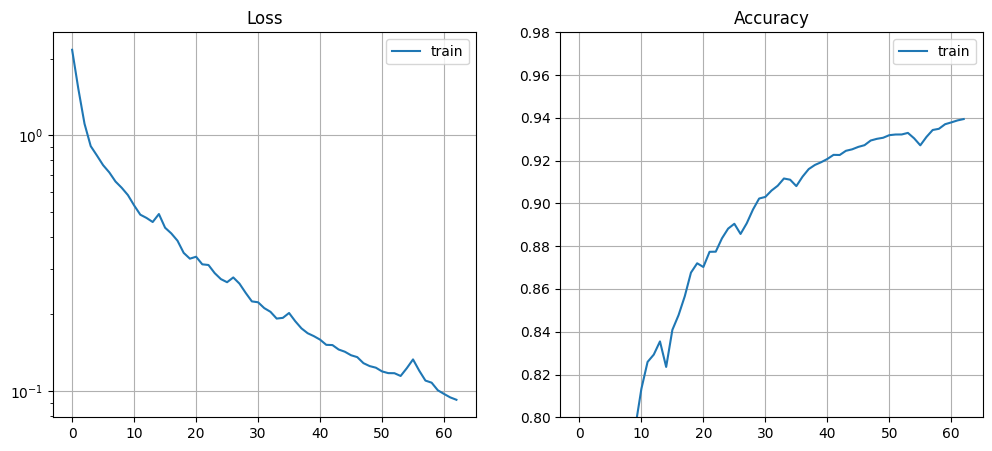

In [ ]:
import matplotlib.pyplot as plt

if train_val:
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].plot(history.history['loss'], label='train')
    ax[0].plot(history.history['val_loss'], label='valid')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[0].grid()
    ax[0].set_yscale("log")

    ax[1].plot(history.history['accuracy'], label='train')
    ax[1].plot(history.history['val_accuracy'], label='valid')
    ax[1].set_title('Accuracy')
    ax[1].legend()
    ax[1].grid()
    ax[1].set_ylim(0.8, 0.95)
    plt.show()

elif train_test:
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].plot(history.history['loss'], label='train')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[0].grid()
    ax[0].set_yscale("log")


    ax[1].plot(history.history['accuracy'], label='train')
    ax[1].set_title('Accuracy')
    ax[1].legend()
    ax[1].grid()
    ax[1].set_ylim(0.8, 0.98)
    plt.show()

# Save model on drive

In [ ]:
# Save model
save_model = True
model_name = 'unet_miniv2'

path = '/content/drive/MyDrive/ColabNotebooks/' + model_name

if save_model:
    unet_model.save(path + '.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Save metrics and model architecture localy